In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# import datasets
from sklearn.datasets import make_moons

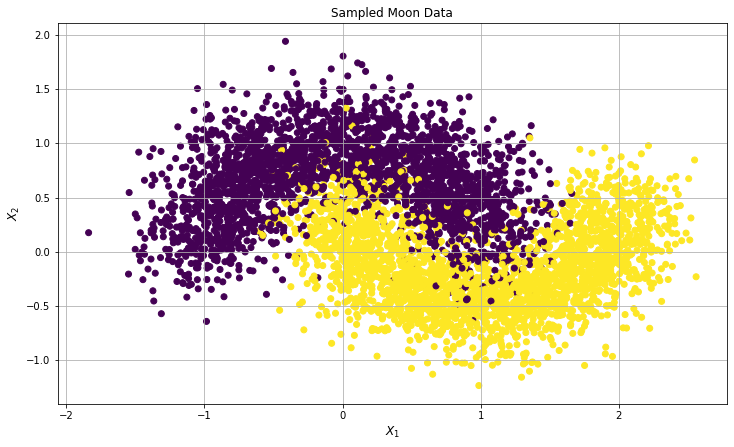

In [117]:
n_samples    = 5000
data_noise   = 0.25 # cov
random_state = 1

x_moon, y_moon = make_moons(n_samples, noise=data_noise, random_state=random_state)


# plot moon data
plt.figure(figsize=(12,7))
plt.scatter(x_moon[:, 0], x_moon[:, 1], c=y_moon)
plt.grid(True)
plt.xlabel('$X_1$', fontsize=12)
plt.ylabel('$X_2$', fontsize=12)
plt.title('Sampled Moon Data')
plt.show()

In [3]:
def train_test_split(target_features, target_labels, train_frac=0.7, seed=1):
    
    # seed random number generator
    np.random.seed(seed)
    
    # get shuffled indices upto data length
    shuffled_indices = np.random.permutation(target_features.shape[0])
    
    train_data_len = int(train_frac*target_features.shape[0])
    
    train_features = target_features[shuffled_indices[0:train_data_len], :]
    train_labels   = target_labels[shuffled_indices[0:train_data_len]]
    
    test_features = target_features[shuffled_indices[train_data_len: ], :]
    test_labels = target_labels[shuffled_indices[train_data_len: ]]
    
    return (train_features, train_labels), (test_features, test_labels)
    

In [4]:
# helper functions to evaluate metrics
def evaluate(test_preds, test_labels, verbose=False):
       
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()

    # calculate binary classification metrics
    recall    = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy  = (tp + tn) / (tp + fp + tn + fn)
    f1_score  = 2.0*recall*precision/(recall + precision)
    
    if (verbose == True):
        # printing a table of metrics
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
    
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy, 'F1_Score': f1_score}

## Use of Activation Functions
Without activation functions, the only mathematical operation during the forward propagation would be dot-products. So, the network will only be able to approximate linear relationships between input and output. But when data becomes more complex, we need to estimate non-linearity/nonlinear mapping between input and output. Because of this reason, we use activation functions at each node, to incorporate nonlinearity in our network.  
The activation functions will also allow us to model interactions between different variables in our network.  

* **Sigmoid function**
  - nonlinear, can map any real value to a space [0, 1]
  - because of the diminishing gradients at 1 and 0, this leads to slow learning rate and vanishing gradient problem
  - not zero centered
* **Tanh function**
  - nonlinear, can map any real value to a space [0, 1]
  - gradient is much steeper compared to **sigmoid** at 0 and 1
  - zero centered
* **[ReLU (Rectified Linear Unit)](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning)**
  - limited type of non-linearity
  - zero gradient for negative values
  - zero centered, easy to compute, faster convergence
  - Because of the zero gradient for values below 0, some weights might never be able to learn
* **[Swish-activation](https://arxiv.org/pdf/1710.05941v1.pdf)**
  - advantages same as ReLU
  - gradient doesn't instantly go to zero for negative values
  - faster acceptance
  
Other types are Leaky ReLU (max(0.001X,X)), Parametric ReLU(max(aX,X)), Exponential ReLU.  
But the most common type that people use are ReLU because of the computational efficiency and better results with faster convergence.  
**Note**: ReLU will be able to model nonlinearities in our model. This can be viewed as follows,  
As the every node in our network includes a bias term, this bias will determine the point where the ReLU goes to zero. Combination of nodes that go to zero at different places, will give us a nonlinear mapping that we are looking for.  
  
#### Advantages of zero-centered activation function

For sigmoid function, the curve is centered around 0.5. Imagine a scenario, when we try to compute $\frac{\partial F}{\partial w1}$ and $\frac{\partial F}{\partial w2}$. If x1 is +ve and x2 is -ve, the activation function will return positive values for some extent and the gradient will be +ve too. So, the optimizer has to move both weights in the same direction.  
Because of this reason, zero-centered activation functions are preferred as it will lead to faster optimization convergence.  

#### Active Research

* [Learning_Combination_of_Activation_Functions](https://arxiv.org/pdf/1801.09403.pdf)

In [74]:
def sigmoid_func(X):
    sigmoid_val = 1.0/(1.0 + np.exp(-X))
    return sigmoid_val

def sigmoid_derivative(X):   
    derivative  = np.subtract(1.0, X)
    derivative  = np.multiply(X, derivative)
    return derivative

# define helper activation functions
def apply_decision_boundary(X):
    return np.where(X > 0.5, 1, 0)

class Sigmoid:
    def __init__(self):
        pass
    
    def func(self, X):
        sigmoid_val = 1.0/(1.0 + np.exp(-X))
        return sigmoid_val
    
    def grad(self, X):
        #sigmoid_val = self.func(X)
        sigmoid_val = X
        derivative  = np.subtract(1.0, sigmoid_val)
        derivative  = np.multiply(sigmoid_val, derivative)
        return derivative
    
class ReLU:
    def __init__(self):
        pass
    
    def func(self, X):
        relu_val = np.where(X < 0.0, 0.0, X)
        return relu_val
    
    def grad(self, X):
        derivative = np.where(X < 0.0, 0.0, 1.0)
        return derivative
    
class Swish(Sigmoid):
    def __init__(self):
        super().__init__()
        pass
    
    def func(self, X):
        sigmoid_val = super().func(X)
        swish_val = np.multiply(X, sigmoid_val)
        return swish_val
    
    def grad(self, X):
#         sigmoid_val = super().func(X)
        sigmoid_val = X
        swish_val = np.multiply(X, sigmoid_val)
        
        additive_term = sigmoid_val * (1.0 - swish_val)
        derivative    = np.add(swish_val, additive_term)
        return derivative

In [75]:
# define loss and fit functions for neural network
def linear_model(data, weights, bias):   
    # model we are fitting is, W*X^T + b
    WX = np.matmul(data, weights)
    WX_b = np.add(WX, bias)
    
    return WX_b

# \to-do: add regularization term to the cost
def cross_entropy_loss(predicted_class, class_labels, class_weight=None):
    sample_len = predicted_class.shape[0]
    
    # work around, instead of supplying 0 to log, supply some small value so as to get the desired affect in the cost
    predicted_class = np.where(predicted_class < 1e-5, 1e-8, predicted_class)
    
    predicted_neg_class = 1.0 - predicted_class
    predicted_neg_class = np.where(predicted_neg_class < 1e-5, 1e-8, predicted_neg_class)
    
    log_prediction_pos_class = np.log(predicted_class)
    log_prediction_neg_class = np.log(predicted_neg_class)
    
    desired_neg_class = np.subtract(1, class_labels)
    desired_pos_class = class_labels
    
    cross_entropy =  np.dot(log_prediction_pos_class.T, desired_pos_class) \
                   + np.dot(log_prediction_neg_class.T, desired_neg_class)
      
    cross_entropy_mean = -cross_entropy/sample_len
    return cross_entropy_mean

# \to-do: update cost function gradient with the regularization term
def cross_entropy_loss_grad(predicted_class, class_labels):
    
    gradient     = np.subtract(predicted_class, class_labels)
    denominator = np.subtract(1.0, predicted_class)
    denominator = np.multiply(predicted_class, denominator)
    denominator = np.where(denominator < 1e-5, 1e-5, denominator)
    
    gradient = np.divide(gradient, denominator)
    return gradient

def cross_entropy_loss_delta(predicted_class, class_labels):
    delta = np.subtract(predicted_class, class_labels)
    return delta

In [190]:
# define a struct neural layer to hold all the information
class NeuralLayer:
    def __init__(self):
        self._weights    = []
        self._bias       = []
        self._n_nodes    = 0
        self._activation = lambda X: X
    
def feed_forward(data, neural_layers):
    # compute equation W^T.X + b
    
    prev_layer_activation = data # n_samples x n_nodes
    n_samples            = data.shape[0]
    
    for layer_idx in range(1, len(neural_layers)):
        this_layer_activation = np.zeros((n_samples, neural_layers[layer_idx]._n_nodes))
        prev_layer_output_len = prev_layer_activation.shape[1]
        
        for node_idx in range(0, neural_layers[layer_idx]._n_nodes):
            weights_start_idx = node_idx*prev_layer_output_len
            weights_end_idx   = weights_start_idx + prev_layer_output_len

            this_layer_activation[:, node_idx] = linear_model(prev_layer_activation, 
                                                              neural_layers[layer_idx]._weights[weights_start_idx:weights_end_idx],
                                                              neural_layers[layer_idx]._bias[node_idx])[:, 0]
            # apply sigmoid function
            this_layer_activation[:, node_idx] = sigmoid_func(this_layer_activation[:, node_idx])
            
        prev_layer_activation = this_layer_activation
    
    prev_layer_activation = apply_decision_boundary(prev_layer_activation)
        
    # final layer output will be of size n_samples x n_nodes   
    return prev_layer_activation

def forward_backward_pass(data, class_labels, neural_layers):
    weight_gradients = [None]*(len(neural_layers)-1) # size: n_weight_terms for each layer
    bias_gradients   = [None]*(len(neural_layers)-1) # size: n_nodes for each layer
    
    # first do feedforward and record all intermidiary output at each node in each layer
    layers_feedforward_info    = [None]*len(neural_layers) # each row will be of size n_samples x n_nodes
    layers_feedforward_info[0] = data
    n_samples                  = data.shape[0]
    
    for layer_idx in range(1, len(neural_layers)):
        layers_feedforward_info[layer_idx] = np.zeros((n_samples, neural_layers[layer_idx]._n_nodes))
        prev_layer_output_len = layers_feedforward_info[layer_idx-1].shape[1]
        
        for node_idx in range(0, neural_layers[layer_idx]._n_nodes):
            weights_start_idx = node_idx*prev_layer_output_len
            weights_end_idx   = weights_start_idx + prev_layer_output_len
            layers_feedforward_info[layer_idx][:, node_idx] = linear_model(layers_feedforward_info[layer_idx-1], 
                                                          neural_layers[layer_idx]._weights[weights_start_idx:weights_end_idx],
                                                          neural_layers[layer_idx]._bias[node_idx])[:, 0]
            
            # apply sigmoid for the current node for the activation
            layers_feedforward_info[layer_idx][:, node_idx] = sigmoid_func(layers_feedforward_info[layer_idx][:, node_idx])
            
    # with the stored intermediary output, calculate gradients of weights and bias using chain-rule
    # partial for the output layer first
    this_layer_sigmoid       = layers_feedforward_info[-1] # size: n_samples x n_nodes in this layer
    prev_layer_sigmoid       = layers_feedforward_info[-2] # size: n_samples x n_nodes in this layer
    
    output_func_grad         = cross_entropy_loss_delta(apply_decision_boundary(this_layer_sigmoid), class_labels) # size: n_samples x n_nodes
    
    weight_gradients[-1]     = np.matmul(output_func_grad.T, prev_layer_sigmoid)
    weight_gradients[-1]     = weight_gradients[-1].reshape((-1, 1))
    weight_gradients[-1]     = weight_gradients[-1]/prev_layer_sigmoid.shape[0]
    
    bias_gradients[-1]       = np.mean(output_func_grad, axis=0)

    # partials for the remaining layers starting from L-1, with L being index for the output layer
    for layer_idx in range(len(neural_layers)-2, 0, -1):
        
        # calculate sigmoid_derivative
        this_layer_sigmoid_prime = sigmoid_derivative(prev_layer_sigmoid)
        prev_layer_sigmoid       = layers_feedforward_info[layer_idx-1]

        # calculate delta
        this_layer_output_func_grad = np.matmul(output_func_grad, neural_layers[layer_idx+1]._weights.T)
        this_layer_output_func_grad = np.multiply(this_layer_output_func_grad, this_layer_sigmoid_prime)
        
        weight_gradients[layer_idx-1] = np.matmul(this_layer_output_func_grad.T, prev_layer_sigmoid)
        weight_gradients[layer_idx-1] = weight_gradients[layer_idx-1].reshape((-1, 1))
        weight_gradients[layer_idx-1] = weight_gradients[layer_idx-1]/prev_layer_sigmoid.shape[0]
        
        bias_gradients[layer_idx-1]   = np.mean(this_layer_output_func_grad, axis=0)
        
        output_func_grad = this_layer_output_func_grad
    
    predicted_result = apply_decision_boundary(layers_feedforward_info[-1])
    return predicted_result, weight_gradients, bias_gradients

In [191]:
def generate_batch_indices(data_len, batch_size=100):   
    shuffle_indexing = np.random.permutation(data_len)
    n_batches        = int(data_len / batch_size)
    
    total_batch_len = n_batches*batch_size
    left_over_data  = data_len - total_batch_len
    
    batch_indices   = [None]*n_batches
    for batch_iter in range(0, n_batches):
        batch_indices[batch_iter] = shuffle_indexing[batch_iter*batch_size : (batch_iter+1)*batch_size]
    
    if (left_over_data > 0):
        batch_indices.append(shuffle_indexing[total_batch_len : data_len])
    
    return batch_indices

def steepest_descent(data, class_labels, neural_layers,
                     cost_func, cost_func_gradient, 
                     n_iter=100, step_size=0.25, regularization_factor=0.01, batch_size=100,
                     class_weight=None, stopping_tol=1e-3):
    
    cost_func_trend  = [None]*(n_iter+1)
    
    initial_class_predictions = feed_forward(data, neural_layers)
    total_cost                = cost_func(initial_class_predictions, class_labels)
    cost_func_trend[0]        = total_cost
    
    error              = total_cost
    weight_decay_rate  = (1.0 - step_size*regularization_factor/(2.0*data.shape[0]))
    for iteration in range(0, n_iter):
        if (error > stopping_tol):
            batch_indices_list = generate_batch_indices(data.shape[0], batch_size)

            for batch_indices in batch_indices_list:
                train_data   = data[batch_indices, :]
                train_labels = class_labels[batch_indices]

                class_predictions, weight_grad, bias_grad = forward_backward_pass(train_data, train_labels, neural_layers)
                
                # update weights
                for layer_idx in range(1, len(neural_layers)):
                    neural_layers[layer_idx]._weights = np.add(weight_decay_rate*neural_layers[layer_idx]._weights, 
                                                               -step_size*weight_grad[layer_idx-1])
                    
                    neural_layers[layer_idx]._bias    = np.add(neural_layers[layer_idx]._bias, 
                                                               -step_size*bias_grad[layer_idx-1])
            
            predicted_class_labels = feed_forward(data, neural_layers)
            loss_this_iter = cost_func(predicted_class_labels, class_labels)
                
            cost_func_trend[iteration+1] = loss_this_iter[0]
            error = np.abs(loss_this_iter - error)
    
    return neural_layers, cost_func_trend

## Initializing weights 

**[Reference](https://arxiv.org/pdf/1704.08863.pdf)**  
Most popular initialization methods are _Xavier/Glorot initialization_ for Sigmoid and Tanh functions and _He initialization_ for ReLU activation functions.
* Xavier/Glorot initialization
  - weights can be sampled from uniform or normal distribution with $\sigma^2 = \frac{1}{N}$
* He initialization
  - weights can be sampled from uniform or normal distribution with $\sigma^2 = \frac{2}{N}$
 
where $N$ is the number of nodes in the previous layer.

In [196]:
# specify layer configuration
# each element specifying number of nodes in that layer
layer_config           = [2, 4, 1]
activation_func_config = [lambda X: X, ReLU(), Sigmoid()]

n_layers         = len(layer_config)
input_layer_dim  = 2
hidden_layer_dim = 3
output_layer_dim = 1

neural_layers    = [None]*n_layers

for layer_idx in range(0, n_layers):
    neural_layers[layer_idx] = NeuralLayer()
    neural_layers[layer_idx]._n_nodes = layer_config[layer_idx]
    if (layer_idx == 0):
        neural_layers[layer_idx]._weights = []
        neural_layers[layer_idx]._bias    = []
    else:
        prev_layer_nodes_len = layer_config[layer_idx-1]
        this_layer_nodes_len = layer_config[layer_idx]
        
        initial_weight_factor = 1.0/np.sqrt(prev_layer_nodes_len)
        neural_layers[layer_idx]._weights = initial_weight_factor*np.random.randn(prev_layer_nodes_len*this_layer_nodes_len, 1)
        neural_layers[layer_idx]._bias    = 0.1*np.ones((this_layer_nodes_len, 1))
    
    neural_layers[layer_idx]._activation = activation_func_config[layer_idx]
    

In [197]:
(x_train, y_train), (x_test, y_test) = train_test_split(x_moon, y_moon, train_frac=0.7)

In [198]:
%%time

# estimate parameters
y_train = y_train.reshape((-1, layer_config[-1]))

# reset neural network weights before estimation
for layer_idx in range(0, n_layers):
    if (layer_idx == 0):
        neural_layers[layer_idx]._weights = []
        neural_layers[layer_idx]._bias    = []
    else:
        prev_layer_nodes_len = layer_config[layer_idx-1]
        this_layer_nodes_len = layer_config[layer_idx]
        
        initial_weight_factor = 3.6/np.sqrt(prev_layer_nodes_len)
        neural_layers[layer_idx]._weights = initial_weight_factor*np.random.randn(prev_layer_nodes_len*this_layer_nodes_len, 1)
        neural_layers[layer_idx]._bias    = 0.1*np.ones((this_layer_nodes_len, 1))

neural_layers, cost_func_trend = steepest_descent(x_train, y_train, neural_layers,
                                                  cross_entropy_loss, cross_entropy_loss_grad, 
                                                  n_iter=300, step_size=0.35, regularization_factor=0.001,
                                                  batch_size=100)

Wall time: 3.69 s


Accuracy on test data ------ 


{'TP': 714,
 'FP': 50,
 'FN': 55,
 'TN': 681,
 'Precision': 0.9345549738219895,
 'Recall': 0.9284785435630689,
 'Accuracy': 0.93,
 'F1_Score': 0.9315068493150684}


Accuracy on trained data ------ 


{'TP': 1607,
 'FP': 120,
 'FN': 124,
 'TN': 1649,
 'Precision': 0.9305153445280834,
 'Recall': 0.9283651068746389,
 'Accuracy': 0.9302857142857143,
 'F1_Score': 0.9294389820705609}

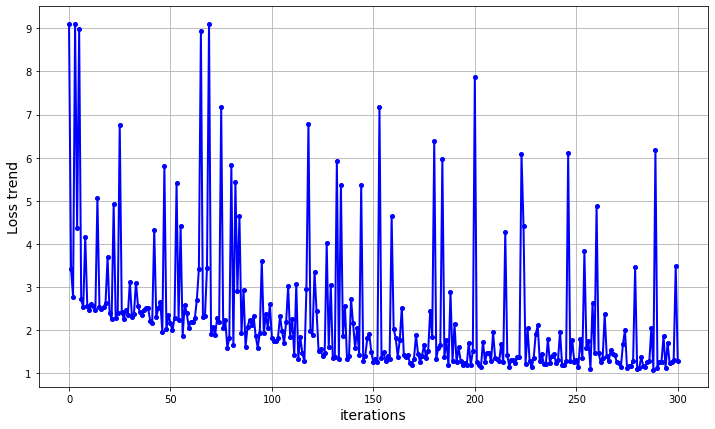

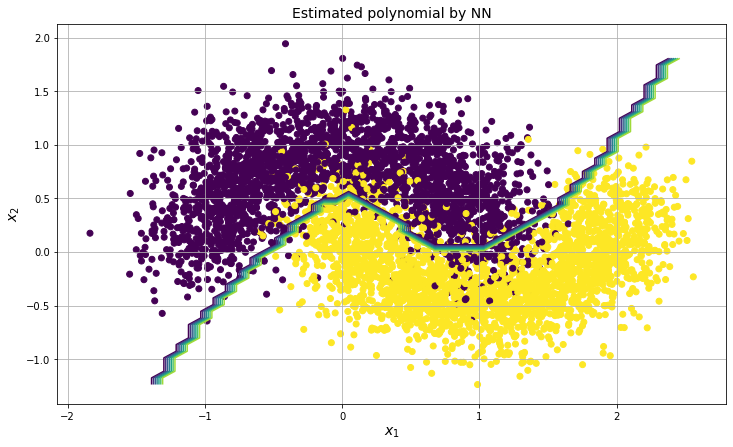

In [199]:
y_test = y_test.reshape((-1, layer_config[-1]))
predicted_labels = feed_forward(x_test, neural_layers)
evaluated_result_test = evaluate(predicted_labels, y_test)

predicted_labels_train = feed_forward(x_train, neural_layers)
evaluated_result_train = evaluate(predicted_labels_train, y_train)

print("Accuracy on test data ------ ")
display(evaluated_result_test)

print("\nAccuracy on trained data ------ ")
display(evaluated_result_train)

# plot cost function trend
plt.figure(figsize=(12,7))
plt.plot(cost_func_trend, 'bo-', markersize=4, linewidth=2)
plt.xlabel('iterations', fontsize=14)
plt.ylabel('Loss trend', fontsize=14)
plt.grid(True)
plt.show()

# plot estimated polynomial by neural network
x1_bounds = np.linspace(np.min(x_train[:, 0]), np.max(x_train[:, 0]), 50)
x2_bounds = np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1]), 50)
x1_mesh, x2_mesh = np.meshgrid(x1_bounds, x2_bounds, sparse=True)
y = []
row = 0
for x1 in x1_mesh[0]:
    col = 0
    y.append([0.0]*50)
    for x2 in x2_mesh:
        X_combined = np.zeros((1, 2))
        X_combined[0, 0] = x1
        X_combined[0, 1] = x2[0]
        y[row][col] = feed_forward(X_combined, neural_layers)[0][0]
        col += 1
    row += 1

plt.figure(figsize=(12,7))
h = plt.contour(x1_bounds, x2_bounds, np.transpose(y))
plt.scatter(x_moon[:, 0], x_moon[:, 1], c=y_moon)
plt.grid(True)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Estimated polynomial by NN', fontsize=14)
plt.show()

### [Tensorflow reference](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

In [ ]:
# using tensorflow
import tensorflow as tf
model = tf.keras.models.Sequential([
                                  tf.keras.layers.Dense(2),
                                  tf.keras.layers.Dense(3, activation='relu'),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(3, activation='relu'),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam',
              loss=loss_fn,
             metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=200)

In [ ]:
metrics = model.evaluate(x_test,  y_test, verbose=2)